# Lab3-4: Introduce to PyTorch; batchnorm + dropout

In [1110]:
import matplotlib.pyplot as plt

import seaborn as sns
import torch 
from torch import nn
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

In [1111]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using CUDA (GPU)


## Task 1

Create model class that takes size of hidden layers, list of layers and activations.

In [1112]:
class MLP_Classifier(nn.Module):
    def __init__(self, input_size: int, output_size: int, sizes: list, activations: list):
        '''
        hidden: number of hidden layers
        input_size: size of first layer
        output_size: size of last layer
        sizes: size of hidden layers
        '''
        super().__init__()      
        sizes = [input_size] + sizes + [output_size]
        layers = list()  
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(activations[i]())
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

## Task 2

Create:
* dataset;
* dataloader;
* train loop.
Lab 4: make batchnorms and dropouts in train loop

In [1113]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

### 1. Dataset and preprocessing

In [1114]:
# https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification/data
df = pd.read_csv("datasets/csgo_round_snapshots.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [1115]:
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


`round_winner` almost no imbalance.

<Axes: xlabel='round_winner', ylabel='Count'>

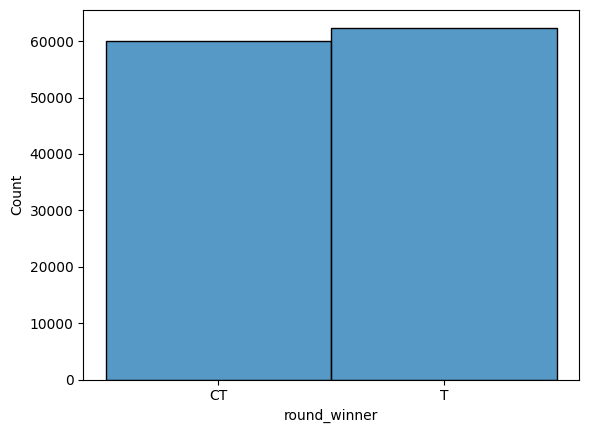

In [1116]:
sns.histplot(df, x="round_winner")

<Axes: xlabel='map', ylabel='Count'>

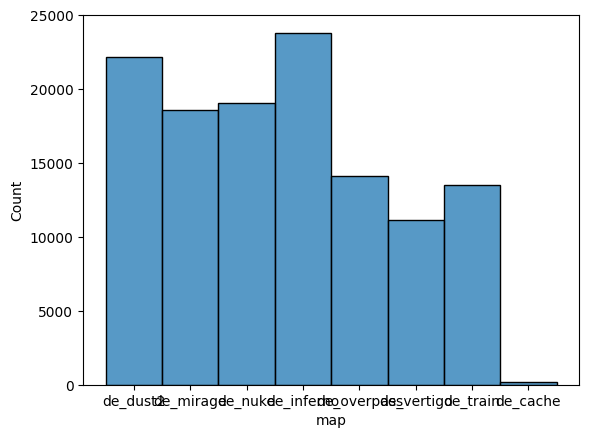

In [1117]:
sns.histplot(df, x="map")

In [1118]:
df = pd.get_dummies(df, columns=['map'])

delete some colums...

In [1119]:
words_to_remove = ['weapon', "t_grenade_hegrenade", "ct_grenade_molotovgrenade", "t_grenade_decoygrenade", "de_cache"]
word_to_keep = ['ak47', "awp", 'ct_weapon_m4a4', 'ct_weapon_usps', 't_weapon_glock']
columns_to_drop = df.columns[df.columns.str.contains('|'.join(words_to_remove))]
columns_to_keep = df.columns[df.columns.str.contains('|'.join(word_to_keep))]

A lot features `weapon` have bad distribution that bad for learning, so we drop this columns, but keep `ak47`, `awp` and anothers.

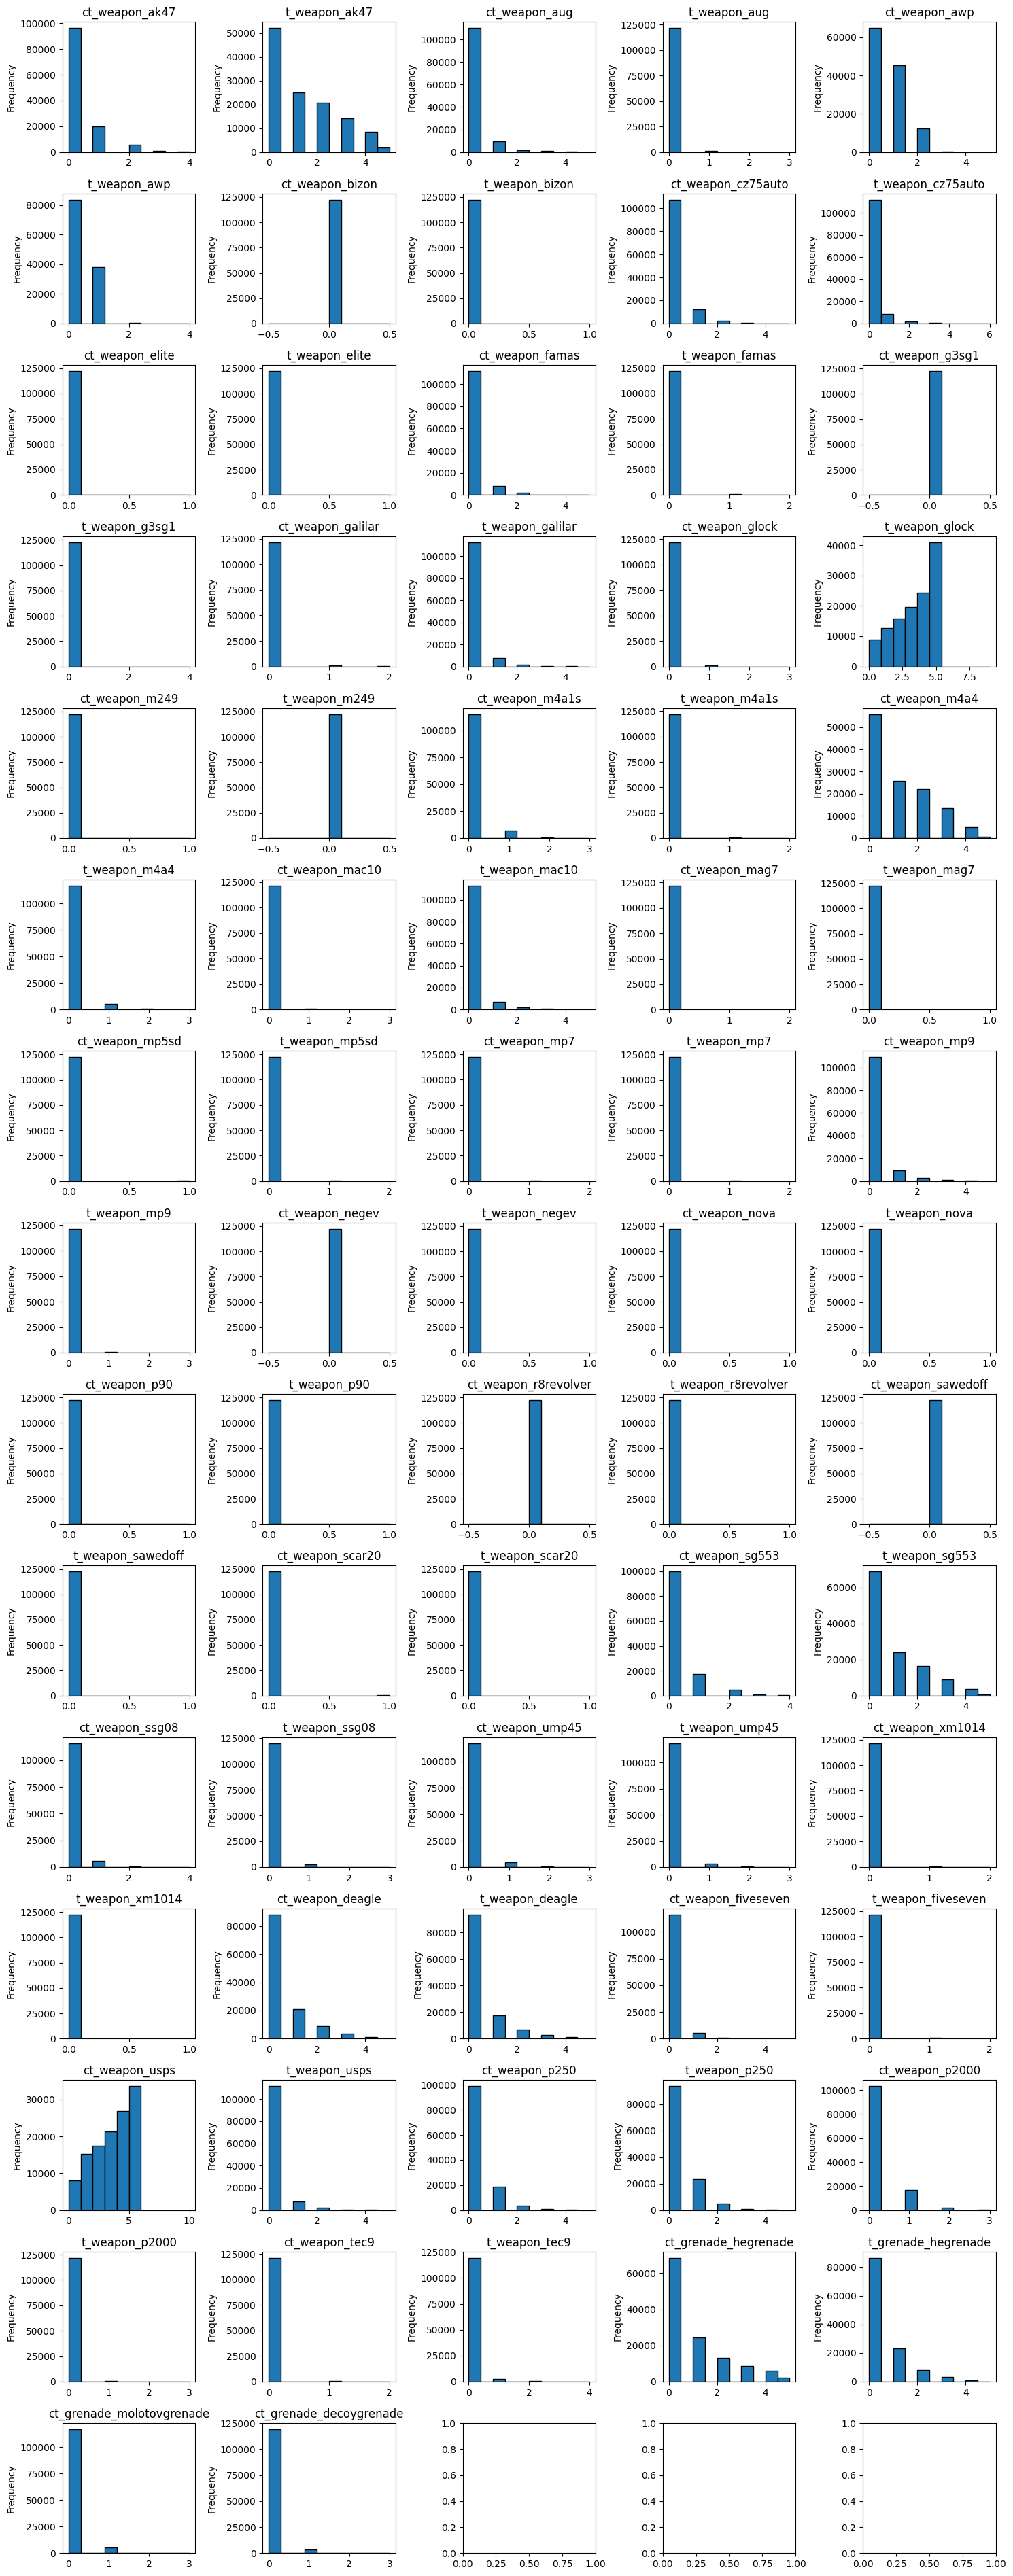

In [1120]:
fig, axes = plt.subplots(nrows=len(columns_to_drop[:-2]) // 5 + 1, ncols=5, figsize=(15,  (len(columns_to_drop[:-2]) // 4 + 1) * 2))

axes = axes.flatten()

for i, column in enumerate(columns_to_drop[:-2]):
    ax = axes[i]
    df[column].plot(kind='hist', ax=ax, title=column, edgecolor='black')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [1121]:
df = df.drop(columns=columns_to_drop.difference(columns_to_keep), axis=1)

In [1122]:
df['round_winner'] = df['round_winner'].map({"CT":0,"T":1})
df['round_winner'].value_counts(normalize=True)

round_winner
1    0.509811
0    0.490189
Name: proportion, dtype: float64

In [1123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   bomb_planted                  122410 non-null  bool   
 4   ct_health                     122410 non-null  float64
 5   t_health                      122410 non-null  float64
 6   ct_armor                      122410 non-null  float64
 7   t_armor                       122410 non-null  float64
 8   ct_money                      122410 non-null  float64
 9   t_money                       122410 non-null  float64
 10  ct_helmets                    122410 non-null  float64
 11  t_helmets                     122410 non-null  float64
 12  ct_defuse_kits                122410 non-nul

### 2. Dataloader

In [1124]:
X = torch.from_numpy(df.drop('round_winner', axis=1).to_numpy().astype(np.float32)).to(torch.float64)
y = torch.from_numpy(df['round_winner'].to_numpy()).to(torch.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.15, random_state=25)

In [1125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = torch.from_numpy(scaler.fit_transform(X_train))
scaled_X_valid = torch.from_numpy(scaler.fit_transform(X_valid))

In [1126]:
BATCH_SIZE = 2048

train_dataset = torch.utils.data.TensorDataset(scaled_X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(scaled_X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 3. Train loop

In [1127]:
learning_rate = 0.01
n_epochs = 500

In [1128]:
layers = [512, 256, 128, 64]
activations = [nn.ReLU]*len(layers) + [nn.Sigmoid]
mlp = MLP_Classifier(X_train.shape[1], 1, layers, activations)
mlp.to(device)
print(mlp)

MLP_Classifier(
  (layers): Sequential(
    (0): Linear(in_features=37, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [1129]:
def train(model, train_loader, optimizer, loss_function):
    model.train()
    
    current_loss = 0.0      
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device).float()
        targets = targets.reshape((targets.shape[0], 1))
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        current_loss += loss.item()
            
    return current_loss/len(train_loader)

In [1130]:
def validate(model, valid_loader, loss_function):
    model.eval()
    valid_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            targets = targets.reshape((targets.shape[0], 1))
            
            output = model(inputs)
            
            loss = loss_function(output, targets)
            
            valid_loss += loss.item()
            
            binary_pred = (output >= 0.5).float()
            correct += (binary_pred==targets).sum().item()

    valid_loss /= len(valid_loader)
    correct /= len(valid_loader.dataset)
    return valid_loss, correct

In [1131]:
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=learning_rate)

loss_function = nn.BCELoss().to(device)

train_loss_list = list()
valid_loss_list = list()
accuracy_list = list()

best_valid = np.inf

for epoch in range(n_epochs):
        
    train_loss = train(mlp, train_loader, optimizer, loss_function)
    train_loss_list.append(train_loss)
    
    valid_loss, accuracy = validate(mlp, valid_loader, loss_function)
    valid_loss_list.append(valid_loss)
    accuracy_list.append(accuracy)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        torch.save(mlp, 'models/lab3-best-model.pt')
        torch.save(mlp.state_dict(), 'models/lab3-best-model-parameters.pt')

    
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}: train_loss = {train_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: valid_loss = {valid_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: accuracy = {accuracy_list[epoch]}")

Epoch 1: train_loss = 0.5155700451018763
Epoch 1: valid_loss = 0.4572499295075734
Epoch 1: accuracy = 0.7536760701448644
Epoch 101: train_loss = 0.1761674428103017
Epoch 101: valid_loss = 0.4542466435167525
Epoch 101: accuracy = 0.8265984097592854
Epoch 201: train_loss = 0.13910582099182933
Epoch 201: valid_loss = 0.6411952707502577
Epoch 201: accuracy = 0.8372181679555604
Epoch 301: train_loss = 0.03274035274836363
Epoch 301: valid_loss = 0.9390403628349304
Epoch 301: accuracy = 0.8356932795991722
Epoch 401: train_loss = 0.0230027161465556
Epoch 401: valid_loss = 1.3515089882744684
Epoch 401: accuracy = 0.8349308354209781


Interesting results... Model retrained (high variance), but accuracy over 80%

<Axes: >

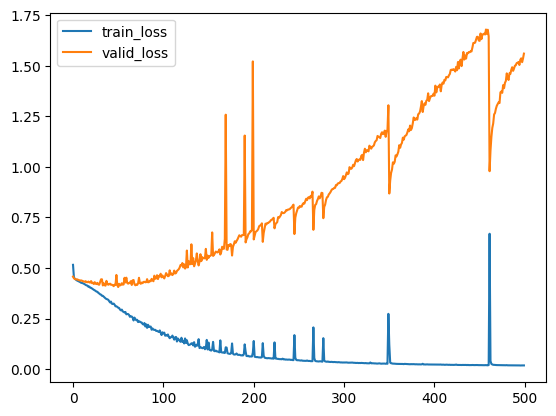

In [1132]:
sns.lineplot(train_loss_list, label="train_loss")
sns.lineplot(valid_loss_list, label="valid_loss")

<Axes: >

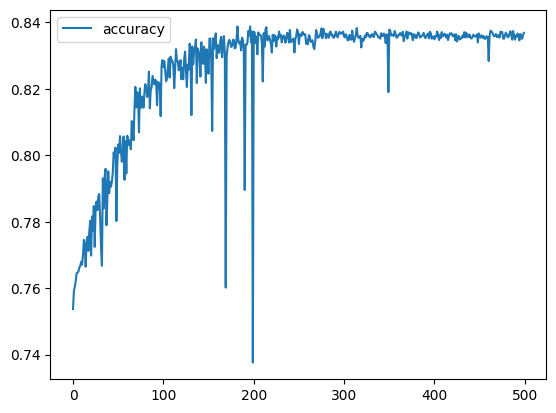

In [1133]:
sns.lineplot(accuracy_list, label="accuracy")

In [1134]:
best_model = mlp
best_model.load_state_dict(torch.load("models/lab3-best-model-parameters.pt"))
best_model.to(device)
best_model.eval()
scaled_X_valid = scaled_X_valid.to(device).float()
with torch.no_grad():
    pred = best_model(scaled_X_valid)

# Convert pred to a float tensor
pred = (pred > 0.5).to(torch.float)

# Calculate accuracy
accuracy = BinaryAccuracy().to(device)
f1_score = BinaryF1Score().to(device)
print(f"Accuracy: {accuracy(pred.squeeze(1), y_valid.to(device))}, f1_score: {f1_score(pred.squeeze(1), y_valid.to(device))}")

Accuracy: 0.8032349348068237, f1_score: 0.8090481758117676


### 4. Batchnorm + dropout

Added dropouts and batch normalization in model

In [1135]:
class MLP_Regularization_Classifier(nn.Module):
    def __init__(self, input_size: int, output_size: int, sizes: list, activations: list, p=0.5):
        '''
        hidden: number of hidden layers
        input_size: size of first layer
        output_size: size of last layer
        sizes: size of hidden layers
        p: dropout probability
        '''
        super().__init__()      
        sizes = [input_size] + sizes + [output_size]
        layers = list()  
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes)-2:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            layers.append(activations[i]())
            if i < len(sizes)-2:
                layers.append(nn.Dropout(p))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [1136]:
layers = [512, 256, 128, 64]
activations = [nn.ReLU]*len(layers) + [nn.Sigmoid]
mlp_reg = MLP_Regularization_Classifier(X_train.shape[1], 1, layers, activations, 0.4)
mlp_reg.to(device)
print(mlp)

MLP_Classifier(
  (layers): Sequential(
    (0): Linear(in_features=37, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [1137]:
optimizer = torch.optim.Adagrad(mlp_reg.parameters(), lr=learning_rate)

best_valid = np.inf

train_loss_list = []
valid_loss_list = []
accuracy_list = []

for epoch in range(n_epochs):
        
    train_loss = train(mlp_reg, train_loader, optimizer, loss_function)
    train_loss_list.append(train_loss)
    
    valid_loss, accuracy = validate(mlp_reg, valid_loader, loss_function)
    valid_loss_list.append(valid_loss)
    accuracy_list.append(accuracy)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        torch.save(mlp_reg, 'models/lab4-best-model.pt')
        torch.save(mlp_reg.state_dict(), 'models/lab4-best-model-parameters.pt')

    
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}: train_loss = {train_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: valid_loss = {valid_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: accuracy = {accuracy_list[epoch]}")

Epoch 1: train_loss = 0.4865105900109983
Epoch 1: valid_loss = 0.4539882739384969
Epoch 1: accuracy = 0.7593399411828777
Epoch 101: train_loss = 0.4155288122448267
Epoch 101: valid_loss = 0.4181419312953949
Epoch 101: accuracy = 0.7845005990632828
Epoch 201: train_loss = 0.3963275078464957
Epoch 201: valid_loss = 0.40223931272824603
Epoch 201: accuracy = 0.797516610391025
Epoch 301: train_loss = 0.3820658215120727
Epoch 301: valid_loss = 0.39226821727222866
Epoch 301: accuracy = 0.8053588933667356
Epoch 401: train_loss = 0.37146953975453095
Epoch 401: valid_loss = 0.38286952177683514
Epoch 401: accuracy = 0.8144537632066223


This looks better!

<Axes: >

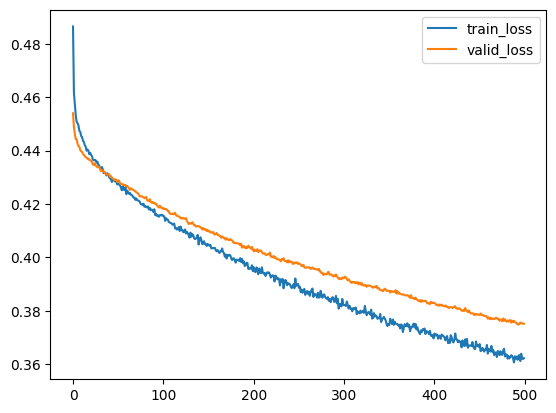

In [1138]:
sns.lineplot(train_loss_list, label="train_loss")
sns.lineplot(valid_loss_list, label="valid_loss")

<Axes: >

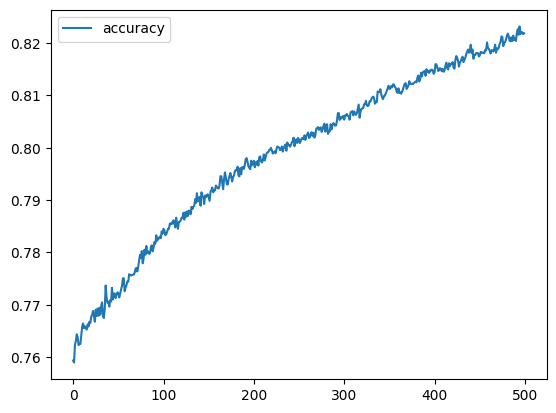

In [1139]:
sns.lineplot(accuracy_list, label="accuracy")

In [1140]:
best_model = mlp_reg
best_model.load_state_dict(torch.load("models/lab4-best-model-parameters.pt"))
best_model.to(device)
best_model.eval()
scaled_X_valid = scaled_X_valid.to(device).float()
with torch.no_grad():
    pred = best_model(scaled_X_valid)

# Convert pred to a float tensor
pred = (pred > 0.5).to(torch.float)

# Calculate accuracy
accuracy = BinaryAccuracy().to(device)
f1_score = BinaryF1Score().to(device)
print(f"Accuracy: {accuracy(pred.squeeze(1), y_valid.to(device))}, f1_score: {f1_score(pred.squeeze(1), y_valid.to(device))}")

Accuracy: 0.8215880393981934, f1_score: 0.8221498131752014
